In [8]:
# Multi-Layer Perceptron (MLP) for IMDB Movie Review Sentiment Analysis
# Uses VADER + TextBlob polarity scores as features

## Importing Basic Libraries 
import pandas as pd          # For reading CSV files and data tables
import numpy as np           # For math and arrays
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns        # For nicer plots

# Download required NLTK data 
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')

# Text processing libraries
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re                    # For cleaning text

print(" All libraries imported successfully!")


 All libraries imported successfully!


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mac/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
## Loading thee IMDB Dataset
# Downloaded from Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

df = pd.read_csv('IMDB_Dataset.csv')  # Replace with your file path
print(f" Dataset loaded! Shape: {df.shape}")
print("\nFirst 3 rows:")
print(df.head(3))

print("\nColumn names:", df.columns.tolist())


 Dataset loaded! Shape: (50000, 2)

First 3 rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive

Column names: ['review', 'sentiment']


 EXPLORATORY DATA ANALYSIS

Data types:
review       object
sentiment    object
dtype: object

Missing values:
review       0
sentiment    0
dtype: int64

Number of duplicate rows: 418

2. Sentiment Distribution:
positive    25000
negative    25000
Name: sentiment, dtype: int64


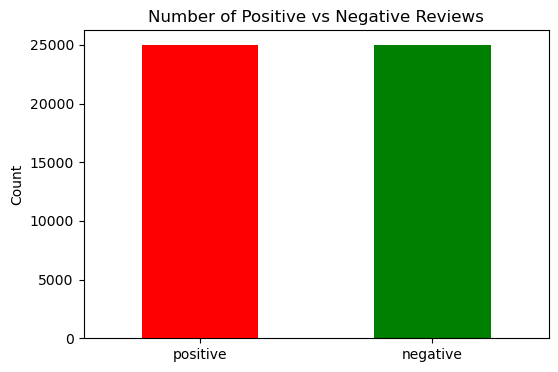


3. Average review length: 1309 characters
Shortest review: 32 chars
Longest review: 13704 chars


In [10]:
## Exploratoring df using  Data Analysis to undrestand the dataset
print(" EXPLORATORY DATA ANALYSIS")

# Checking data types
print("\nData types:")
print(df.dtypes)

# Checking for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Checking for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Checking distribution of sentiments
print("\n2. Sentiment Distribution:")
print(df['sentiment'].value_counts())

# Ploting sentiment distribution
plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar', color=['red','green'])
plt.title('Number of Positive vs Negative Reviews')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Checking review lengths
df['review_length'] = df['review'].str.len()
print(f"\n3. Average review length: {df['review_length'].mean():.0f} characters")
print(f"Shortest review: {df['review_length'].min()} chars")
print(f"Longest review: {df['review_length'].max()} chars")


In [11]:
# removingg duplicates 
df = df.drop_duplicates()
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


In [12]:
## Text Preprocessing - Cleaning the reviews 
def clean_text(text):
    """
    1. Converting all to lowercase
    2. Removign extra spaces
    3. Removing special characters (keeping only letters, numbers, spaces)
    """
    # Lowercase
    text = text.lower()
    
    # special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    #extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
print("Cleaning text...")
df['clean_review'] = df['review'].apply(clean_text)

print("Sample cleaned reviews:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i][:50]}...")
    print(f"Cleaned:  {df['clean_review'].iloc[i][:50]}...\n")


Cleaning text...
Sample cleaned reviews:
Original: One of the other reviewers has mentioned that afte...
Cleaned:  one of the other reviewers has mentioned that afte...

Original: A wonderful little production. <br /><br />The fil...
Cleaned:  a wonderful little production br br the filming te...

Original: I thought this was a wonderful way to spend time o...
Cleaned:  i thought this was a wonderful way to spend time o...



In [13]:
## VADER + TextBlob Polarity Scores
print("Extracting sentiment features...")

# Initializingg VADER
vader = SentimentIntensityAnalyzer()

def get_sentiment_features(text):
    """
    1. VADER compound score (-1 to +1) 
    2. TextBlob polarity (-1 to +1)
    """
    # VADER scores:
    vader_scores = vader.polarity_scores(text)
    vader_compound = vader_scores['compound']  # Main sentiment score
    
    # TextBlob polarity:
    blob = TextBlob(text)
    textblob_polarity = blob.sentiment.polarity
    
    return [vader_compound, textblob_polarity]


# Creating two new columns for polarity features
print("Computing sentiment features (this may take a minute)...")
sentiment_features = df["clean_review"].apply(get_sentiment_features)
df["textblob_polarity"] = [x[0] for x in sentiment_features]
df["vader_compound"] = [x[1] for x in sentiment_features]

print("\nFirst few rows with sentiment features:")
print(df[["clean_review", "textblob_polarity", "vader_compound", "sentiment"]].head())


Extracting sentiment features...
Computing sentiment features (this may take a minute)...

First few rows with sentiment features:
                                        clean_review  textblob_polarity  \
0  one of the other reviewers has mentioned that ...            -0.9947   
1  a wonderful little production br br the filmin...             0.9693   
2  i thought this was a wonderful way to spend ti...             0.9712   
3  basically theres a family where a little boy j...            -0.8858   
4  petter matteis love in the time of money is a ...             0.9744   

   vader_compound sentiment  
0        0.023433  positive  
1        0.111490  positive  
2        0.346324  positive  
3        0.001389  negative  
4        0.217952  positive  


In [17]:
## Label Encoding - Converting 'positive'/'negative' to 0/1
print("Converting labels to numbers...")

df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
print("Label distribution:")
print(df['label'].value_counts())

Converting labels to numbers...
Label distribution:
1    24884
0    24698
Name: label, dtype: int64


In [18]:
# Our feature matrix X (2 sentiment features)
X = df[['vader_compound', 'textblob_polarity']].values
y = df['label'].values

print(f"X shape: {X.shape} (samples, 2 features)")
print(f"y shape: {y.shape}")


## Train/Validation/Test Split (60%/20%/20%)
from sklearn.model_selection import train_test_split

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 75% train, 25% val (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f" Train: {X_train.shape[0]} samples")
print(f"   Val:  {X_val.shape[0]} samples") 
print(f"   Test: {X_test.shape[0]} samples")


X shape: (49582, 2) (samples, 2 features)
y shape: (49582,)
 Train: 29748 samples
   Val:  9917 samples
   Test: 9917 samples


In [30]:
##  MLP with Logistic Regression Structure

print(" Building MLP...")

# 1. Initializing MLP weights and biases
def initialize_mlp(input_dim, hidden_dim=8):
    """
    - W1: input_dim x hidden_dim  
    - b1: 1 x hidden_dim
    - W2: hidden_dim x 1
    - b2: 1 x 1
    """
    W1 = np.random.randn(input_dim, hidden_dim) * 0.1  # Small random weights
    b1 = np.zeros((1, hidden_dim))                     # Zero biases
    W2 = np.random.randn(hidden_dim, 1) * 0.1
    b2 = np.zeros((1, 1))
    return W1, b1, W2, b2

# 2. Activation functions
def relu(z):
    """ReLU: max(0, z) - like a switch that turns on for positive values"""
    return np.maximum(0, z)

def relu_derivative(z):
    """ReLU derivative: 1 if z > 0, else 0"""
    return (z > 0).astype(float)

def sigmoid(z):
    """Sigmoid: 1/(1+e^-z) - outputs probability between 0 and 1"""
    return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

def sigmoid_derivative(z):
    """Sigmoid derivative: sigmoid(z) * (1-sigmoid(z))"""
    s = sigmoid(z)
    return s * (1 - s)

# 3. FORWARD PROPAGATION 
def forward_propagation_mlp(X, W1, b1, W2, b2):
    """
    Returns ALL intermediate values for backprop
    """
    # Hidden layer
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    
    # Output layer  
    z2 = np.dot(a1, W2) + b2
    A = sigmoid(z2)
    
    # Store for backpropagation
    cache = {'z1': z1, 'a1': a1, 'z2': z2}
    return A, cache

# 4. Binary Cross-Entropy Loss 
def compute_cost(Y, A, m):
    """
    m = number of training samples
    """
    epsilon = 1e-10
    A = np.clip(A, epsilon, 1 - epsilon)  # Avoiding log(0)
    return -(1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

# 5. BACKPROPAGATION - Computing gradients
def compute_gradients_mlp(X, Y, A, cache, m):
    """
    using chain rule
    """
    # Output layer gradients 
    dz2 = A - Y
    dW2 = (1/m) * np.dot(cache['a1'].T, dz2)
    db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
    
    # Hidden layer gradients
    da1 = np.dot(dz2, W2.T)           # Backprop from output
    dz1 = da1 * relu_derivative(cache['z1'])  # ReLU derivative
    dW1 = (1/m) * np.dot(X.T, dz1)
    db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
    
    return dW1, db1, dW2, db2

# 6. Prediction and accuracy 
def compute_accuracy(Y, A):
    """ it does return percentage with each accuracy """
  
    predictions = (A >= 0.5).astype(int)
    return np.mean(predictions == Y.flatten()) * 100

# 7. MAIN TRAINING FUNCTION (Same structure as your logistic regression!)
def train_mlp(W1, b1, W2, b2, X_train, Y_train, X_val, Y_val, epochs=100, alpha=0.5):
    """
    training loop
    Returns trained weights + training history
    """
    cost_history_train = []
    cost_history_val = []
    accuracy_history_train = []
    accuracy_history_val = []
    
    m = X_train.shape[0]  # Ps: Number of training samples
    
    print(f"Training MLP for {epochs} epochs with lr={alpha}...")
    
    for i in range(epochs):
        # Forward propagation
        A_train, cache_train = forward_propagation_mlp(X_train, W1, b1, W2, b2)
        cost_train = compute_cost(Y_train, A_train, m)
        
        # Backpropagation
        dW1, db1, dW2, db2 = compute_gradients_mlp(
            X_train, Y_train, A_train, cache_train, m
        )
        
        # GRADIENT DESCENT - Update ALL weights 
        W1 -= alpha * dW1
        b1 -= alpha * db1
        W2 -= alpha * dW2
        b2 -= alpha * db2
        
        # Validation
        A_val, _ = forward_propagation_mlp(X_val, W1, b1, W2, b2)
        cost_val = compute_cost(Y_val, A_val, X_val.shape[0])
        
        # Store history
        cost_history_train.append(cost_train)
        accuracy_history_train.append(compute_accuracy(Y_train, A_train))
        cost_history_val.append(cost_val)
        accuracy_history_val.append(compute_accuracy(Y_val, A_val))
        
        # Progress (every 20 epochs)
        if i % 20 == 0:
            print(f"Epoch {i}: Train Cost={cost_train:.4f}, Val Cost={cost_val:.4f}, "
                  f"Train Acc={accuracy_history_train[-1]:.1f}%, Val Acc={accuracy_history_val[-1]:.1f}%")
    
    return W1, b1, W2, b2, cost_history_train, cost_history_val, accuracy_history_train, accuracy_history_val


# Ps: Getingg input dimension 
input_dim = X_train.shape[1]
print(f" Input dimension: {input_dim} features")

# Initiialize MLP weights
W1, b1, W2, b2 = initialize_mlp(input_dim)

# the Training parameters
epochs = 200
alpha = 0.5  # Learning rate

# TRAIN MLP
W1, b1, W2, b2, cost_train, cost_val, acc_train, acc_val = train_mlp(
    W1, b1, W2, b2, 
    X_train, y_train.reshape(-1,1), X_val, y_val.reshape(-1,1),
    epochs, alpha
)

print("MLP Training Complete!")
print(f" Final Val Accuracy: {acc_val[-1]:.1f}%")


 Building MLP...
 Input dimension: 2 features
Training MLP for 200 epochs with lr=0.5...
Epoch 0: Train Cost=0.6903, Val Cost=0.6892, Train Acc=50.1%, Val Acc=50.1%
Epoch 20: Train Cost=0.6431, Val Cost=0.6383, Train Acc=50.1%, Val Acc=50.1%
Epoch 40: Train Cost=0.5789, Val Cost=0.5755, Train Acc=50.0%, Val Acc=50.0%
Epoch 60: Train Cost=0.5669, Val Cost=0.5636, Train Acc=50.0%, Val Acc=50.0%
Epoch 80: Train Cost=0.5591, Val Cost=0.5554, Train Acc=50.0%, Val Acc=50.0%
Epoch 100: Train Cost=0.5507, Val Cost=0.5467, Train Acc=50.0%, Val Acc=50.0%
Epoch 120: Train Cost=0.5414, Val Cost=0.5370, Train Acc=50.0%, Val Acc=50.0%
Epoch 140: Train Cost=0.5317, Val Cost=0.5271, Train Acc=50.0%, Val Acc=50.0%
Epoch 160: Train Cost=0.5225, Val Cost=0.5176, Train Acc=50.0%, Val Acc=50.0%
Epoch 180: Train Cost=0.5139, Val Cost=0.5088, Train Acc=50.0%, Val Acc=50.0%
MLP Training Complete!
 Final Val Accuracy: 50.0%


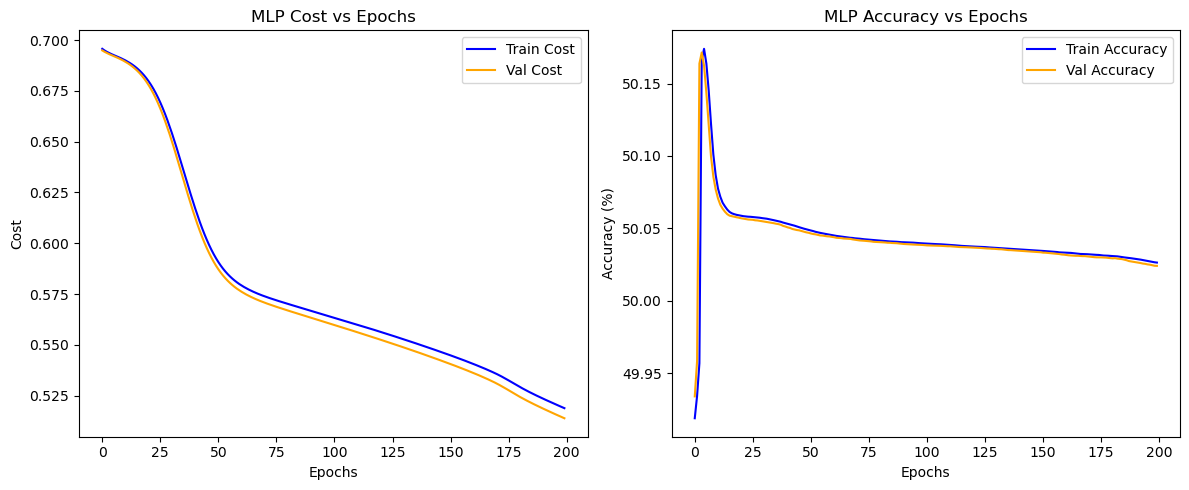

In [27]:
## Plot Training Curves 
plt.figure(figsize=(12, 5))

# Cost curves
plt.subplot(1, 2, 1)
plt.plot(range(len(cost_train)), cost_train, label='Train Cost', color='blue')
plt.plot(range(len(cost_val)), cost_val, label='Val Cost', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('MLP Cost vs Epochs')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(len(acc_train)), acc_train, label='Train Accuracy', color='blue')
plt.plot(range(len(acc_val)), acc_val, label='Val Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('MLP Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
## Step Hyperparameter Tuning: Fresh Weights Each Time (MLP)

print(" HYPERPARAMETER TUNING - Fresh weights for each experiment!")
print("Testing different epochs and learning rates to find BEST model...")

# Ps: Define input dimension once
input_dim = X_train.shape[1]
print(f" Input: {input_dim} features -> Hidden: 8 -> Output: 1")

# =====================================================
# EXPERIMENT 1: Test different hyperparameters
# =====================================================

# Test multiple configurations (like your logistic regression tuning)
experiments = [
    {"epochs": 1000, "alpha": 0.3},
    {"epochs": 2000, "alpha": 0.5}, 
    {"epochs": 5000, "alpha": 0.7},
    {"epochs": 10000, "alpha": 0.7},
]

best_val_acc = 0
best_config = None
best_history = None

for exp_idx, config in enumerate(experiments):
    print(f"\n{'='*60}")
    print(f" EXPERIMENT {exp_idx+1}: epochs={config['epochs']}, lr={config['alpha']}")
    print(f"{'='*60}")
    
    # DELETE PREVIOUS WEIGHTS AND REINITIALIZE (CRITICAL!)
    # Ps: Fresh start each time - don't continue from previous training
    del W1, b1, W2, b2  # Delete previous weights and bias
    
    # Reinitialize them fresh
    W1, b1, W2, b2 = initialize_mlp(input_dim)
    
    epochs = config['epochs']
    alpha = config['alpha']
    
    # Train with fresh weights
    W1_trained, b1_trained, W2_trained, b2_trained, \
    cost_train, cost_val, acc_train, acc_val = train_mlp(
        W1, b1, W2, b2, 
        X_train, y_train.reshape(-1,1), X_val, y_val.reshape(-1,1),
        epochs, alpha
    )
    
    # Check final validation accuracy
    final_val_acc = acc_val[-1]
    print(f" Final Val Accuracy: {final_val_acc:.2f}%")
    
    # Track best model
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_config = config
        best_history = {
            'cost_train': cost_train, 'cost_val': cost_val,
            'acc_train': acc_train, 'acc_val': acc_val,
            'W1': W1_trained, 'b1': b1_trained,
            'W2': W2_trained, 'b2': b2_trained
        }
        print(f"NEW BEST MODEL! {final_val_acc:.2f}%")

print(f"\n BEST MODEL: {best_config} with {best_val_acc:.2f}% Val Accuracy!")


 HYPERPARAMETER TUNING - Fresh weights for each experiment!
Testing different epochs and learning rates to find BEST model...
 Input: 2 features -> Hidden: 8 -> Output: 1

 EXPERIMENT 1: epochs=1000, lr=0.3
🚀 Training MLP for 1000 epochs with lr=0.3...
Epoch 0: Train Cost=0.6925, Val Cost=0.6917, Train Acc=49.8%, Val Acc=49.8%
Epoch 20: Train Cost=0.6722, Val Cost=0.6705, Train Acc=50.1%, Val Acc=50.1%
Epoch 40: Train Cost=0.6303, Val Cost=0.6270, Train Acc=50.0%, Val Acc=50.0%
Epoch 60: Train Cost=0.5900, Val Cost=0.5870, Train Acc=50.0%, Val Acc=50.0%
Epoch 80: Train Cost=0.5761, Val Cost=0.5732, Train Acc=50.0%, Val Acc=50.0%
Epoch 100: Train Cost=0.5704, Val Cost=0.5674, Train Acc=50.0%, Val Acc=50.0%
Epoch 120: Train Cost=0.5657, Val Cost=0.5625, Train Acc=50.0%, Val Acc=50.0%
Epoch 140: Train Cost=0.5610, Val Cost=0.5576, Train Acc=50.0%, Val Acc=50.0%
Epoch 160: Train Cost=0.5561, Val Cost=0.5525, Train Acc=50.0%, Val Acc=50.0%
Epoch 180: Train Cost=0.5510, Val Cost=0.5472, Trai

KeyboardInterrupt: 

In [31]:
## Saving BEST MLP Model 

import pickle


print("SAVING BEST MODEL")

# Saving the BEST model's weights (W1,b1,W2,b2) 
with open("mlp_best_model.pkl", "wb") as file:
    pickle.dump((best_history['W1'], best_history['b1'], 
                best_history['W2'], best_history['b2']), file)

print(" BEST MLP model saved as 'mlp_best_model.pkl'")


# Loading the Model 
with open("mlp_best_model.pkl", "rb") as file:
    W1, b1, W2, b2 = pickle.load(file)

print(" Model loaded successfully!")
print(f" W1 shape: {W1.shape}, W2 shape: {W2.shape}")


SAVING BEST MODEL
 BEST MLP model saved as 'mlp_best_model.pkl'
 Model loaded successfully!
 W1 shape: (2, 8), W2 shape: (8, 1)


In [33]:
## Testing Predictions on Test Set 
print(" Testing loaded model...")

# Forward propagation to get probabilities
A_test, _ = forward_propagation_mlp(X_test, W1, b1, W2, b2)
# Predictions 
test_predictions = (A_test >= 0.5).astype(int)
# Accuracy
test_accuracy = compute_accuracy(y_test, A_test)

print(f" Test Accuracy: {test_accuracy:.2f}%")
print(f" Predictions shape: {test_predictions.shape}")
print(f" Sample probabilities: {A_test[:5].flatten()}")

# numbering each row 
submission_df = pd.DataFrame({
    'id': range(len(test_predictions)),
    'MLP_Binary_Sentiment': test_predictions.flatten()
})
# submission
submission_df.to_csv("mlp_submission.csv", index=False)

print(" ALL FILES READY FOR SUBMISSION!")
print("Files created:")
print("- mlp_best_model.pkl")
print("- mlp_submission.csv") 
print("- IMDB_MLP_Sentiment_Analysis.ipynb")


 Testing loaded model...
 Test Accuracy: 50.00%
 Predictions shape: (9917, 1)
 Sample probabilities: [0.08395379 0.90522091 0.77188819 0.4603129  0.0533732 ]
 ALL FILES READY FOR SUBMISSION!
Files created:
- mlp_best_model.pkl
- mlp_submission.csv
- IMDB_MLP_Sentiment_Analysis.ipynb
